In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install transformers
!pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.3 MB

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [5]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    # zip 파일 압축 해제
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [6]:
import random
random.seed(42)
galleries = ['animal','tree']#,'ktwiz','kartriderdrift','skwyverns_new1','ncdinos','samsunglions_new','doosanbears_new1','giants_new2','sh_new','lgtwins_new','tigers_new']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [7]:
def remove_words(sentence, word):
    return ' '.join([w for w in sentence.split() if w != word])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장']#['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [8]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [9]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [10]:
from transformers import AutoModel, AutoTokenizer
from umap import UMAP
# umap_model = UMAP(random_state=42)
# umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
model = AutoModel.from_pretrained("klue/roberta-large")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
class CustomTokenizer:
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer
  # def __call__(self, target):
  #   return self.tokenizer.tokenize(target)
  def __call__(self, target):
    tokens = self.tokenizer.tokenize(target)
    if isinstance(tokens[0], str):
      indices = [i for i, token in enumerate(tokens) if not token.startswith('##')]
      tokens = [tokens[i] for i in indices]
    elif isinstance(tokens[0][0], str):
      for j in range(len(tokens)):
        indices = [i for i, token in enumerate(tokens[j]) if not token.startswith('##')]
        tokens[j] = [tokens[j][i] for i in indices]
    return tokens

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

custom_tokenizer = CustomTokenizer(tokenizer)
# vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_features=3000)
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_features=3000)

In [13]:
# from umap import UMAP
# from hdbscan import HDBSCAN

# umap_model = UMAP(n_neighbors=5, n_components=5, metric='cosine', low_memory=False)
# hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)

In [14]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          top_n_words=1)
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       # umap_model=umap_model,
#                                       # hdbscan_model=hdbscan_model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=3,
#                                       calculate_probabilities=False)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [15]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)
for i in lst:
  print(i)

생성된 주제의 수: 99
햄스터
로보쿤
이거
꽃이
신엽
물을
잎이
가격
흑설기와
이거
식물
날씨
쥐친구
식물등
병원
jpg
터널
흙에
사료
찢어진
거미줄
이름이
과일트럭에서
이름이
잠자는쥐
귀엽다
고양이
냄새
핸들링
쳇바퀴
나무인가요
서울
뚱땡정글
우리집
오르비
모래
토마토
강아지를
코코넛
비둘기
쥐가
케이지
놔라
맛있음
생태계교란
캄차쿠노름표
플로리다
알로카시아
유혈목이
기니피그
화장실
일베
마시는
호캉스
수컷이
빨리
딸기
뽀뽀
올리브
사진
유튜브
햄스터
바다직박구리
갤러
블루베리
입제
올해
고양이
심은
냉장고를
사진
돼지
동물임
나무위키
ㅇㅇ
물꽂이
당근마켓
높이
멍청햄
하우스
녹소토
난건지
실신시킴
잎분무
제라늄
버섯이
식쇼
모습들
코코봉
김나나
무늬
유통기한
기운이
거북이
공간이
강아지
죽은걸까요
교환
행잉


In [16]:
table = [[0 for r in range(2)] for t in range(number_of_topics)]

for j in range(number_of_topics):
  for i in range(len(topics)):
    if topics[i]==j:
      table[j][real_labels[i]]+=1
print(table)

[[1313, 0], [620, 534], [281, 345], [11, 538], [83, 248], [20, 278], [1, 241], [53, 139], [140, 21], [34, 106], [1, 135], [46, 76], [114, 0], [1, 108], [94, 11], [100, 3], [46, 48], [2, 92], [70, 17], [31, 47], [14, 64], [10, 67], [50, 25], [0, 73], [68, 3], [50, 19], [58, 11], [38, 30], [60, 5], [52, 8], [3, 56], [23, 30], [46, 4], [38, 11], [12, 36], [45, 2], [0, 40], [39, 0], [36, 2], [36, 1], [37, 0], [34, 2], [22, 13], [24, 7], [29, 1], [17, 13], [10, 19], [1, 27], [27, 1], [26, 1], [21, 5], [26, 0], [15, 10], [0, 24], [24, 0], [1, 21], [5, 17], [19, 2], [0, 20], [19, 0], [10, 9], [19, 0], [15, 3], [0, 18], [3, 14], [2, 15], [2, 15], [15, 2], [0, 16], [16, 0], [5, 10], [14, 1], [15, 0], [13, 2], [14, 1], [0, 14], [4, 10], [6, 8], [13, 1], [4, 9], [0, 13], [10, 3], [12, 1], [0, 12], [0, 12], [0, 12], [0, 12], [12, 0], [4, 8], [11, 1], [3, 9], [3, 8], [2, 9], [9, 2], [5, 6], [8, 3], [0, 11], [0, 11], [2, 8]]


In [17]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

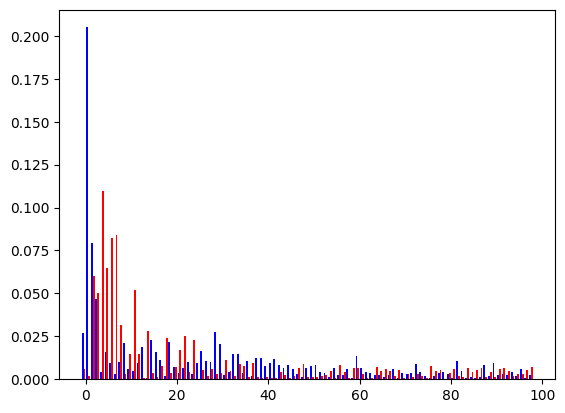

In [18]:
import matplotlib.pyplot as plt

colors = ["#0000FF", "#FF0000"]

data = [[] for _ in range(len(dataset))]
for j in range(len(dataset)):
    data[j] = [topics[i] for i in range(len(real_labels)) if real_labels[i] == j]
    # plt.hist(data[j], bins=number_of_topics, color=colors[j], histtype='bar')
    # plt.show()

plt.hist(data, bins=number_of_topics, color=colors, histtype='bar', density=True)
plt.show()

In [19]:
import numpy as np
npdata = [[] for _ in range(len(dataset))]
for j in range(len(dataset)):
  npdata[j] = np.array([0] * (number_of_topics + 1), dtype=np.float32)
  for k in range(len(data[j])):
    npdata[j][data[j][k] + 1] += 1
  npdata[j] /= npdata[j].sum()

In [20]:
topic_ = [[], []]
threshold = 5
for k in range(number_of_topics):
  ratio = max((npdata[0][k] + 1e-12) / (npdata[1][k] + 1e-12), (npdata[1][k] + 1e-12) / (npdata[0][k] + 1e-12))
  if ratio > threshold:
    if npdata[0][k] > npdata[1][k]:
      topic_[0].append((k - 1, npdata[0][k], npdata[1][k]))
    else:
      topic_[1].append((k - 1, npdata[0][k], npdata[1][k]))

for k in range(len(topic_)):
  topic_[k].sort(key=lambda x: x[k + 1], reverse=True)
  for j, v0, v1 in topic_[k]:
    print('\t'.join([x[0] for x in bertopic_model_embed_token.get_topic(j)]), j, v0, v1, sep='\t')
  print()

햄스터	0	0.20498376	0.0020753038
핸들링	28	0.027410617	0.0028658959
병원	14	0.023076924	0.0038541357
사료	18	0.021451788	0.0037553117
흑설기와	8	0.021018418	0.0028658959
쳇바퀴	29	0.020585049	0.0038541357
쥐친구	12	0.018959913	0.00088941597
jpg	15	0.01603467	0.0012847119
뚱땡정글	32	0.014626219	0.0019764798
코코넛	38	0.012567714	0.0009882399
강아지를	37	0.012242687	0.0015811839
케이지	41	0.011809317	0.00088941597
고양이	26	0.010725894	0.0020753038
모래	35	0.010617551	0.001185888
쥐가	40	0.009750812	0.0009882399
잠자는쥐	24	0.009317443	0.00039529597
김나나	89	0.009317443	0.001185888
화장실	50	0.008450705	0.0015811839
생태계교란	44	0.008342362	0.00069176796
모습들	87	0.008125677	0.0012847119
비둘기	39	0.0079089925	0.0013835359
기니피그	49	0.00780065	0.0010870639
수컷이	54	0.006608884	0.00088941597
유혈목이	48	0.0065005417	0.0010870639
뽀뽀	57	0.006067172	0.00088941597
햄스터	61	0.0043336945	0.00079059193
멍청햄	78	0.0042253523	0.00019764798
바다직박구리	62	0.0036836404	0.00069176796
냉장고를	69	0.0034669556	0.00069176796

꽃이	3	0.0044420366	0.109793454
잎이	6	0.0029252437	0.08380

In [21]:
for k in range(len(npdata)):
  data = sorted([(i - 1, v) for i, v in enumerate(npdata[k].tolist())], key=lambda x: x[1], reverse=True)
  for i in range(10):
    print('\t'.join([x[0] for x in bertopic_model_embed_token.get_topic(data[i][0])]), data[i][0], data[i][1], sep='\t')
  print()

햄스터	0	0.20498375594615936
로보쿤	1	0.07952329516410828
이거	2	0.04669555649161339
핸들링	28	0.027410617098212242
너무	-1	0.026868905872106552
병원	14	0.023076923564076424
사료	18	0.021451788023114204
흑설기와	8	0.021018417552113533
쳇바퀴	29	0.02058504894375801
쥐친구	12	0.01895991340279579

꽃이	3	0.10979345440864563
잎이	6	0.08380274474620819
물을	5	0.08202391862869263
신엽	4	0.0647297129034996
로보쿤	1	0.0602826364338398
식물	10	0.052080243825912476
이거	2	0.05010376498103142
가격	7	0.03132720664143562
식물등	13	0.02786836586892605
이름이	21	0.025200119242072105



In [22]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:01<00:00, 73.43it/s]


In [ ]:
# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
# hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail, linkage_function=linkage_function)

In [23]:
bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)